In [252]:
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil.relativedelta import relativedelta
local_base_url = 'http://localhost:2000'

In [253]:
import os
import sys

backend_path = os.path.abspath(os.path.join(os.getcwd(), '../backend'))
sys.path.append(backend_path)

from app.internal.firebase import db

In [125]:
exchange_token = "100"
smallcase_name = "Amara Raja Energy & Mobility Ltd"

start_date = "2023-12-15"
end_date = "2024-03-14"

q = await db.collection("tickers").where("smallcase_name", "==", smallcase_name).get()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/google/cloud/firestore_v1/base_collection.py:290: UserWarning: Detected filter using positional arguments. Prefer using the 'filter' keyword argument instead.
  return query.where(field_path, op_string, value)
/Users/aaryanpagar/Library/Python/3.11/lib/python/site-packages/google/api_core/retry/retry_unary.py:146: UserWarning: Using the synchronous google.api_core.retry.Retry with asynchronous calls may lead to unexpected results. Please use google.api_core.retry_async.AsyncRetry instead.
  warnings.warn(_ASYNC_RETRY_WARNING)


In [126]:
if q:
    equity = q[0].to_dict()
    resp = requests.get(f"{local_base_url}/tickers/{equity['exchange_token']}/candles?start_date={start_date}&end_date={end_date}")
    print(resp.status_code)

200


In [127]:
candles: dict = resp.json()

In [128]:
df_train = pd.DataFrame.from_dict(candles, orient="index")
df_train.index.name = "date"
df_train.head()

,open,high,low,close,volume,open_interest
date,,,,,,
2023-12-15,774.50,779.90,763.05,765.25,352696,0
2023-12-18,768.90,789.45,757.15,781.25,965918,0
2023-12-19,789.95,799.60,778.25,781.95,846627,0
2023-12-20,784.00,786.50,737.80,743.80,935363,0
2023-12-21,731.55,765.25,728.50,762.45,661832,0


In [129]:
df_train.to_csv("candles.csv")

In [130]:
import math
import numpy as np
from datetime import datetime
from dateutil.relativedelta import relativedelta

In [131]:
dates = list(candles.keys())
n = len(dates)

returns = []
for i in range(n - 1):
    prev_price = candles[dates[i]]["close"]
    next_price = candles[dates[i + 1]]["close"]
    r = math.log(prev_price / next_price)
    returns.append(r)

s = sum(returns)
n -= 1 # Adjusting for the last data point
mean = s / n
print("Mean:", mean)

q = 0
for r in returns:
    q += (r - mean) ** 2

print("Sum of squared deviations:", q)
print("Variance:", q / n)

variance = np.var(returns)
print("Variance:", variance)
print("SD:", variance ** 0.5)

print(s, n, s/n)



Mean: -0.0006940839300399
Sum of squared deviations: 0.02625307663087031
Variance: 0.0004234367198527469
Variance: 0.00042343671985274703
SD: 0.02057757808520592
-0.0430332036624738 62 -0.0006940839300399


### Backtesting

In [132]:
DATE_FORMAT = "%Y-%m-%d"
smallcase_id = "SCAW_0001"
quarter_end = "2019-01-01"
params = {"date": quarter_end}

smallcase = requests.get(f"{local_base_url}/smallcases/{smallcase_id}").json()
constituents = requests.get(f"{local_base_url}/smallcases/{smallcase_id}/constituents", params=params).json()

start_date = constituents["start_date"]
end_date = constituents["end_date"]

# prev_start_date = datetime.strptime(start_date, DATE_FORMAT) - relativedelta(months=3)
# prev_start_date = prev_start_date.strftime(DATE_FORMAT)

# prev_end_date = datetime.strptime(end_date, DATE_FORMAT) - relativedelta(months=3)
# prev_end_date = prev_end_date.strftime(DATE_FORMAT)

In [133]:
async def get_candles_from_smallcase_name(smallcase_name: str, start_date, end_date):
    q = await db.collection("tickers").where("smallcase_name", "==", smallcase_name).get()
    if q:
        equity = q[0].to_dict()
        resp = requests.get(f"{local_base_url}/tickers/{equity['exchange_token']}/candles?start_date={start_date}&end_date={end_date}")
        if resp.status_code == 200:
            return resp.json()
        print(resp.status_code, "Not Found")

In [134]:
async def get_candles(constituents, start_date, end_date):
    candles = {}
    for c in constituents:
        # Maybe BE can have a call for this
        ticker = await db.collection("tickers").where("smallcase_name", "==", c["smallcase_name"]).get()
        if ticker:
            ticker = ticker[0].to_dict()
            params = {"start_date": start_date, "end_date": end_date}
            resp = requests.get(f"{local_base_url}/tickers/{ticker['exchange_token']}/candles", params=params)
            candles[c["smallcase_name"]] = resp.json()

    return candles

In [135]:
c = constituents["constituents"]
candles = await get_candles(c, start_date, end_date)
len(candles) == len(c)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/google/cloud/firestore_v1/base_collection.py:290: UserWarning: Detected filter using positional arguments. Prefer using the 'filter' keyword argument instead.
  return query.where(field_path, op_string, value)
/Users/aaryanpagar/Library/Python/3.11/lib/python/site-packages/google/api_core/retry/retry_unary.py:146: UserWarning: Using the synchronous google.api_core.retry.Retry with asynchronous calls may lead to unexpected results. Please use google.api_core.retry_async.AsyncRetry instead.
  warnings.warn(_ASYNC_RETRY_WARNING)


True

In [136]:
candles_at_inception = {}
inception_date = "2018-07-18"

for constituent in c:
    ticker = await db.collection("tickers").where("smallcase_name", "==", constituent["smallcase_name"]).get()
    if ticker:
        ticker = ticker[0].to_dict()
        resp = requests.get(f"{local_base_url}/tickers/{ticker['exchange_token']}/candles/{inception_date}")
        candles_at_inception[constituent["smallcase_name"]] = resp.json()

len(candles_at_inception) == len(c)

True

In [137]:
def calculate_index(constituents: list, inception_date: str, date: str) -> int:
    index = 100
    indexes = 0
    for c in constituents:
        try:
            name = c["smallcase_name"]
            weight = c["original_weightage"]

            close = candles[name][date]["close"]
            close_at_inception = candles_at_inception[name]["daily"][inception_date]["close"]

            investable_shares = (index * weight) / close_at_inception
            indexes += investable_shares * close
            
        except KeyError as e:
            print(e)
            print(f"Candle not found for {name}. Skipping index on {date}.")
            continue
    return indexes


In [138]:
indexes = calculate_index(c, inception_date, "2019-03-27")
indexes

103.66443091913047

## Expected Value

In [254]:
import requests
import numpy as np
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

BASE_URL = "http://localhost:2000"

In [378]:
smallcase_name = "Nippon India ETF Nifty Next 50 Junior BeES"
exchange_token = "10939"
quarter_end = "2023-03-31"
quarter_start = "2023-01-01"


quarter_prev = (pd.to_datetime(quarter_start) - pd.DateOffset(years=7)).strftime("%Y-%m-%d")

params = {"start_date": quarter_prev , "end_date": quarter_start}
train_candles = requests.get(f"{BASE_URL}/tickers/{exchange_token}/candles", params=params).json()
test_candles = []
test_candles = requests.get(f"{BASE_URL}/tickers/{exchange_token}/candles", params={"start_date": quarter_start, "end_date": quarter_end}).json()
len(train_candles), len(test_candles)

(1734, 0)

In [256]:
df_train = pd.DataFrame.from_dict(train_candles, orient="index")
df_train.index = pd.to_datetime(df_train.index)
df_test = pd.DataFrame.from_dict(test_candles, orient="index")
df_test.index = pd.to_datetime(df_test.index)

df_close = df_train["close"].to_frame()
df_close.head()

df_train.head()

,open,high,low,close,volume,open_interest
2018-01-01,320.0,320.00,314.21,315.50,9019,0
2018-01-02,315.4,316.50,311.50,313.16,10425,0
2018-01-03,322.5,322.50,313.84,314.55,3730,0
2018-01-04,315.1,319.02,315.00,318.84,10774,0
2018-01-05,320.0,322.50,319.67,322.25,13503,0


In [258]:
m = 4 # Quarterly data
model = auto_arima(df_close, seasonal=True, m=m)
best_order = model.get_params()["order"]
best_seasonal_order = model.get_params()["seasonal_order"]
best_order, best_seasonal_order

((1, 1, 0), (0, 0, 0, 4))

In [259]:
def get_expected_value(candles: list):
    model = ARIMA(candles, order=best_order)
    model_fit = model.fit()    
    expected_value = model_fit.forecast()
    return expected_value[0]

In [262]:
temp = df_close["close"].values
train_split = int(0.9 * len(temp)) # 60-40 split
train, test = temp[:train_split], temp[train_split:]


historical_candles = [c for c in train]
expected_values = []
for candle in test:
    expected_values.append(get_expected_value(historical_candles))
    historical_candles.append(candle)


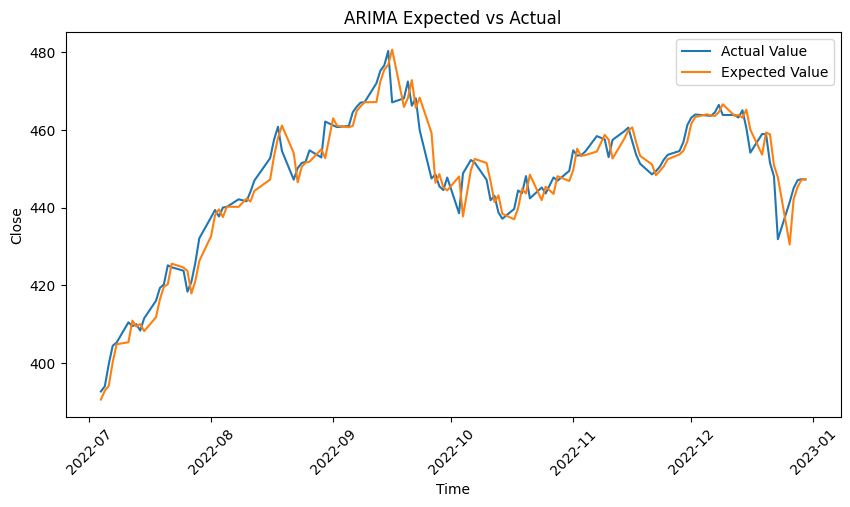

In [263]:
plt.figure(figsize=(10, 5))
plt.title('ARIMA Expected vs Actual')
plt.xlabel('Time')
plt.ylabel('Close')
plt.xticks(rotation=45)
plt.plot(df_close.iloc[train_split:].index, test, label='Actual Value')
plt.plot(df_close.iloc[train_split:].index, expected_values, label='Expected Value')
plt.legend()
plt.show()

In [267]:
mae = mean_absolute_error(test, expected_values)
mse = mean_squared_error(test, expected_values)

adjusted_mae = (mae / np.mean(test)) * 100
adjusted_mse = (mse / np.mean(test)) * 100

print(f"Adjusted MAE: {adjusted_mae} %, Adjusted MSE: {adjusted_mse} %")

Adjusted MAE: 0.7075562039981929 %, Adjusted MSE: 4.035718047379238 %


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


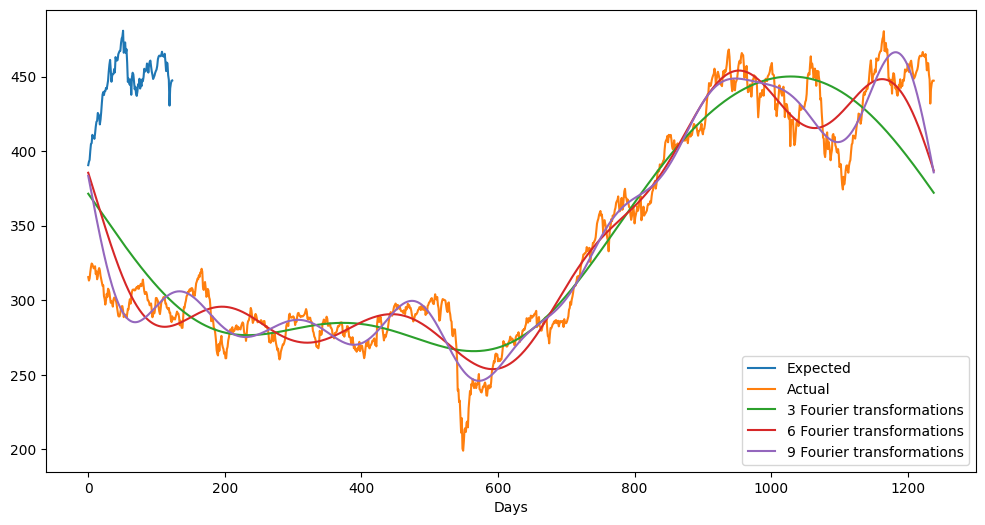

In [268]:
close_prices = df_close[['close'][:len(expected_values)]]
close_prices_array = close_prices['close'].values.tolist()
fourier_close = np.fft.fft(np.asarray(close_prices['close'].tolist()))
df_fourier = pd.DataFrame({'fourier':fourier_close})
df_fourier['absolute'] = df_fourier['fourier'].apply(lambda x: np.abs(x))
df_fourier['angle'] = df_fourier['fourier'].apply(lambda x: np.angle(x))

plt.figure(figsize=(12, 6))
plt.plot(expected_values, label='Expected')
plt.plot(close_prices_array,  label='Actual')
for num_ in [3, 6, 9]:
    fourier_list= np.copy(fourier_close); fourier_list[num_:-num_]=0
    plt.plot(np.fft.ifft(fourier_list), label='{} Fourier transformations'.format(num_))
plt.xlabel('Days')
plt.legend()
plt.show()

### Test using quarterly returns instead of expected price

In [283]:
returns_train = df_train["close"].resample('Q').ffill().pct_change().dropna()

df_prev_quarter = df_train[df_train.index.max() - pd.DateOffset(months=3):]
df_quarter_on_quarter = pd.concat([df_prev_quarter, df_test])
returns_test = df_quarter_on_quarter["close"].resample('Q').ffill().pct_change().dropna()


len(returns_train), len(returns_test)

/var/folders/lq/280gf8ld14v161g6ngpdjjnc0000gn/T/ipykernel_54121/2804306443.py:1: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  returns_train = df_train["close"].resample('Q').ffill().pct_change().dropna()
/var/folders/lq/280gf8ld14v161g6ngpdjjnc0000gn/T/ipykernel_54121/2804306443.py:5: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  returns_test = df_quarter_on_quarter["close"].resample('Q').ffill().pct_change().dropna()


(19, 2)

In [348]:
model = auto_arima(returns_train, m=4, seasonal=True)
best_order = model.get_params()["order"]
best_seasonal_order = model.get_params()["seasonal_order"]
best_order, best_seasonal_order

((0, 0, 0), (0, 0, 0, 4))

In [344]:
def get_expected_value(candles: list):
    model = ARIMA(candles, order=(3, 1, 3))
    model_fit = model.fit()    
    expected_value = model_fit.forecast()
    return expected_value[0]

In [349]:
model = ARIMA(returns_train, order=(8, 1, 7))
model_fit = model.fit()
forecast = model_fit.forecast(1, alpha=0.05)
forecast

/Users/aaryanpagar/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/aaryanpagar/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/aaryanpagar/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


2023-03-31    0.220251
Freq: QE-DEC, dtype: float64

In [350]:
returns_test

2022-12-31   -0.001161
2023-03-31   -0.104644
Freq: QE-DEC, Name: close, dtype: float64

In [345]:
temp = returns_train.values
train_split = int(0.6 * len(temp))
train, test = temp[:train_split], temp[train_split:]

histotical_returns = [r for r in train]
expected_values = []
for r in test:
    expected_values.append(get_expected_value(histotical_returns))
    histotical_returns.append(r)

/Users/aaryanpagar/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/aaryanpagar/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/aaryanpagar/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/aaryanpagar/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/aaryanpag

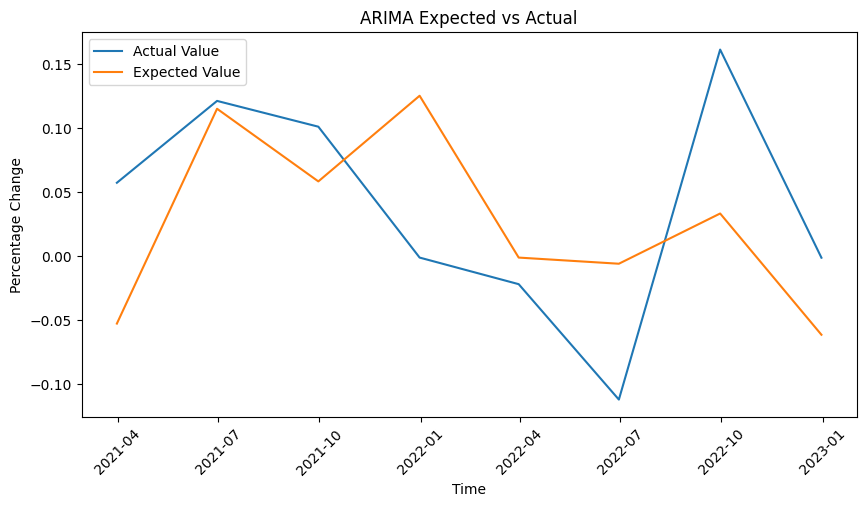

In [346]:
plt.figure(figsize=(10, 5))
plt.title("ARIMA Expected vs Actual")
plt.xlabel("Time")
plt.ylabel("Percentage Change")
plt.xticks(rotation=45)
plt.plot(returns_train.iloc[train_split:].index, test, label="Actual Value")
plt.plot(returns_train.iloc[train_split:].index, expected_values, label="Expected Value")
plt.legend()
plt.show()